In [1]:
import numpy as np
import pandas as pd
import sklearn
import re
import seaborn as sns
try:
    import xgboost 
    from xgboost import XGBClassifier
except ImportError:
    print("Please install xgboost, refer to https://xgboost.readthedocs.io/en/latest/build.html")
try:
    import featexp
except ImportError:
    print("Please install featexp by pip.")
import matplotlib.pyplot as plt

import time
from datetime import datetime
now = datetime.now().strftime('%Y%m%d%H%M%S')
print("Now is {}".format(now))

import warnings
warnings.filterwarnings(action ='ignore')
from hyperopt import hp, fmin, tpe
from sklearn.metrics import accuracy_score
from functools import partial
from sklearn.ensemble import RandomForestClassifier
# import subprocess
# print(subprocess.check_output(['conda','env', 'list']))

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

# TODO: run pip or self package

Now is 20181202123725


In [2]:
from jinja2 import Environment, ChoiceLoader, FileSystemLoader
from IPython.display import HTML, display
from pandas.io.formats.style import Styler

%mkdir templates

A subdirectory or file templates already exists.


In [3]:
%%file templates/myhtml.tpl
{% extends "html.tpl" %}
{% block table %}
<h1>{{ table_title|default("My Table") }}</h1>
{{ super() }}
{% endblock table %}

Overwriting templates/myhtml.tpl


In [4]:
class MyStyler(Styler):
    env = Environment(
        loader=ChoiceLoader([
            FileSystemLoader("templates"),  # contains ours
            Styler.loader,  # the default
        ])
    )
    template = env.get_template("myhtml.tpl")

In [5]:
def color_05_red(val):
    color = 'red' if val < 0.5 else 'black'
    return 'color: %s' % color

In [6]:
import logging
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')


def setup_logger(name, log_file, level=logging.INFO):
    """Function setup as many loggers as you want"""

    handler = logging.FileHandler(log_file)        
    handler.setFormatter(formatter)

    logger = logging.getLogger(name)
    logger.setLevel(level)
    logger.addHandler(handler)

    return logger

# first file logger
logger = setup_logger('first_logger', 'first_logfile.log')
logger.info('This is just info message')

# second file logger
super_logger = setup_logger('second_logger', 'second_logfile.log')
super_logger.error('This is an error message')

In [7]:
train_df = pd.read_csv('all//train.csv')
test_df = pd.read_csv('all//test.csv')

In [8]:
train_df.info()
test_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Baseline 

In [9]:
def baseline(features, train_df, test_df, Target="Survived"):
    
    features.append(Target)
    data1 = train_df.copy()[features]
    features.pop()
    Target = [Target]
        #Machine Learning Algorithm (MLA) Selection and Initialization
    MLA = [
        #Ensemble Methods
        ensemble.AdaBoostClassifier(),
        ensemble.BaggingClassifier(),
        ensemble.ExtraTreesClassifier(),
        ensemble.GradientBoostingClassifier(),
        ensemble.RandomForestClassifier(),

        #Gaussian Processes
        gaussian_process.GaussianProcessClassifier(),

        #GLM
        linear_model.LogisticRegressionCV(),
        linear_model.PassiveAggressiveClassifier(),
        linear_model.RidgeClassifierCV(),
        linear_model.SGDClassifier(),
        linear_model.Perceptron(),

        #Navies Bayes
        naive_bayes.BernoulliNB(),
        naive_bayes.GaussianNB(),

        #Nearest Neighbor
        neighbors.KNeighborsClassifier(),

        #SVM
        svm.SVC(probability=True),
        svm.NuSVC(probability=True),
        svm.LinearSVC(),

        #Trees    
        tree.DecisionTreeClassifier(),
        tree.ExtraTreeClassifier(),

        #Discriminant Analysis
        discriminant_analysis.LinearDiscriminantAnalysis(),
        discriminant_analysis.QuadraticDiscriminantAnalysis(),


        #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
        XGBClassifier()    
        ]



    #split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
    #note: this is an alternative to train_test_split
    cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

    #create table to compare MLA metrics
    MLA_columns = ['MLA Name', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Time','MLA Parameters',]
    MLA_compare = pd.DataFrame(columns = MLA_columns)

    #create table to compare MLA predictions
    MLA_predict = data1[Target]

    #index through MLA and save performance to table
    row_index = 0
    for alg in MLA:

        #set name and parameters
        MLA_name = alg.__class__.__name__
        MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
        MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

        #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
        cv_results = model_selection.cross_validate(alg, data1[features].values, data1[Target].values.ravel(), cv  = cv_split)

        MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
        MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
        MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   


        #save MLA predictions - see section 6 for usage
        alg.fit(data1[features], data1[Target])
        MLA_predict[MLA_name] = alg.predict(data1[features])

        row_index+=1


    #display and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
    MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
    display(HTML(MyStyler(MLA_compare).render(table_title="Model Cross Validation Accuracies with feature {}".format('+'.join(features)))))
#     return MLA_compare
    
def submit(train_prediction, test_prediction, label, features, train_df, test_df):
    
    submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": test_prediction
    })
    submission.to_csv('titanic_baseline_{}_with_{}.csv'.format(label, '+'.join(features)), index=False)
    
    print('Exported')   


# Encoding

In [10]:
train_df['Sex'].replace(['male','female'],[0,1],inplace=True)
test_df['Sex'].replace(['male','female'],[0,1],inplace=True)

train_df.loc[train_df['Embarked']=='S', 'Embarked']=0
train_df.loc[train_df['Embarked']=='C', 'Embarked']=1
train_df.loc[train_df['Embarked']=='Q', 'Embarked']=2

test_df.loc[test_df['Embarked']=='S', 'Embarked']=0
test_df.loc[test_df['Embarked']=='C', 'Embarked']=1
test_df.loc[test_df['Embarked']=='Q', 'Embarked']=2

# Data Cleaning

In [11]:
# Check for missing data & list them 
nas = pd.concat([train_df.isnull().sum(), test_df.isnull().sum()], axis=1, keys=['Train Dataset', 'Test Dataset']) 
print('Nan in the data sets')
print(nas[nas.sum(axis=1) > 0])

Nan in the data sets
          Train Dataset  Test Dataset
Age                 177          86.0
Cabin               687         327.0
Embarked              2           0.0
Fare                  0           1.0


In [12]:
# Missing values

train_df['Age']=train_df['Age'].fillna(train_df.loc[train_df['Age'].notnull()]['Age'].mean())
train_df['Cabin'] = train_df['Cabin'].fillna(train_df['Cabin'].value_counts().index[0])
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].value_counts().index[0])

test_df['Age']=test_df['Age'].fillna(test_df.loc[train_df['Age'].notnull()]['Age'].mean())
test_df['Cabin'] = test_df['Cabin'].fillna(test_df['Cabin'].value_counts().index[0])
test_df['Embarked'] = test_df['Embarked'].fillna(test_df['Embarked'].value_counts().index[0])
test_df['Fare']=test_df['Fare'].fillna(test_df.loc[train_df['Fare'].notnull()]['Fare'].mean())

# Scale numbers
train_df['Fare'] = (train_df['Fare']-train_df['Fare'].min())/(train_df['Fare'].max()-train_df['Fare'].min())
test_df['Fare'] = (test_df['Fare']-test_df['Fare'].min())/(test_df['Fare'].max()-test_df['Fare'].min())
# Assure no missing values
nas = pd.concat([train_df.isnull().sum(), test_df.isnull().sum()], axis=1, keys=['Train Dataset', 'Test Dataset']) 
if nas[nas.sum(axis=1) > 0].empty:
    print("No missing values.")
else:        
    print('Nan in the data sets')
    print(nas[nas.sum(axis=1) > 0])

No missing values.


# EDA & Feature Generation

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null int64
dtypes: float64(2), int64(7), object(3)
memory usage: 83.6+ KB


## Correlation

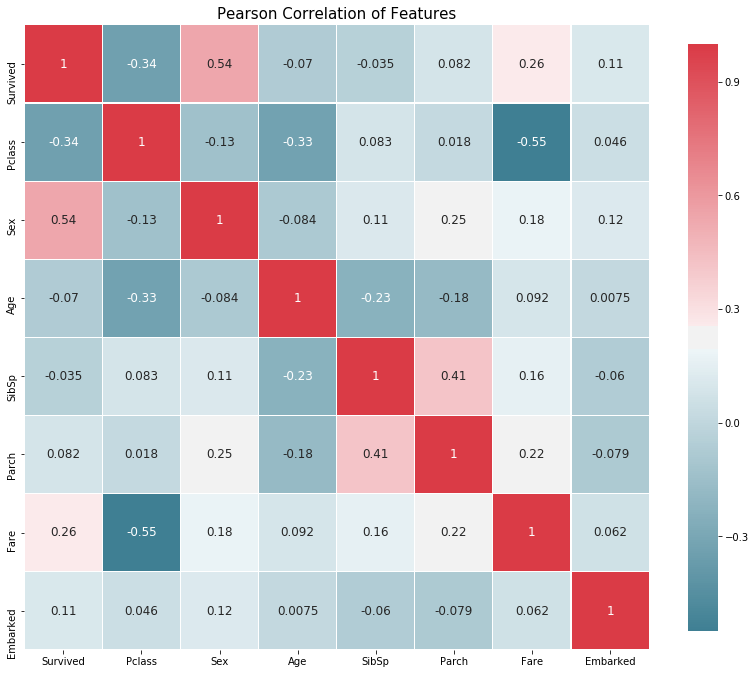

In [14]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(train_df.copy().drop(["PassengerId"], axis=1))

## Strong correlated features

In [15]:
baseline(['Sex', 'Pclass'], train_df, test_df)

,MLA Name,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time,MLA Parameters
0,AdaBoostClassifier,0.78839,0.78806,0.0715088,"{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}"
8,RidgeClassifierCV,0.78839,0.78806,0.0013962,"{'alphas': (0.1, 1.0, 10.0), 'class_weight': None, 'cv': None, 'fit_intercept': True, 'normalize': False, 'scoring': None}"
20,QuadraticDiscriminantAnalysis,0.78839,0.78806,0.00039885,"{'priors': None, 'reg_param': 0.0, 'store_covariance': False, 'store_covariances': None, 'tol': 0.0001}"
19,LinearDiscriminantAnalysis,0.78839,0.78806,0.000798082,"{'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}"
16,LinearSVC,0.78839,0.78806,0.00847716,"{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}"
12,GaussianNB,0.78839,0.78806,0.000997376,{'priors': None}
11,BernoulliNB,0.78839,0.78806,0.000698113,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True}"
6,LogisticRegressionCV,0.793633,0.783209,0.047473,"{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'refit': True, 'scoring': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0}"
1,BaggingClassifier,0.79382,0.783209,0.0125664,"{'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
5,GaussianProcessClassifier,0.79382,0.783209,0.135637,"{'copy_X_train': True, 'kernel': None, 'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_jobs': 1, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None, 'warm_start': False}"


## Plots with featexp

                                           Plots for Pclass                                           


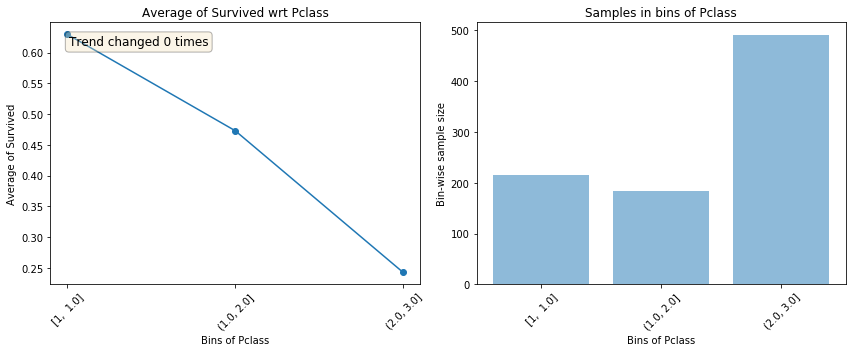

--------------------------------------------------------------------------------------------------------------


                                           Plots for SibSp                                            


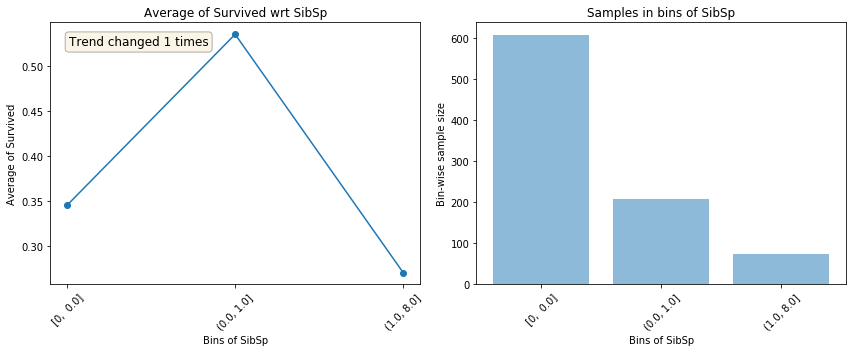

--------------------------------------------------------------------------------------------------------------


                                           Plots for Parch                                            


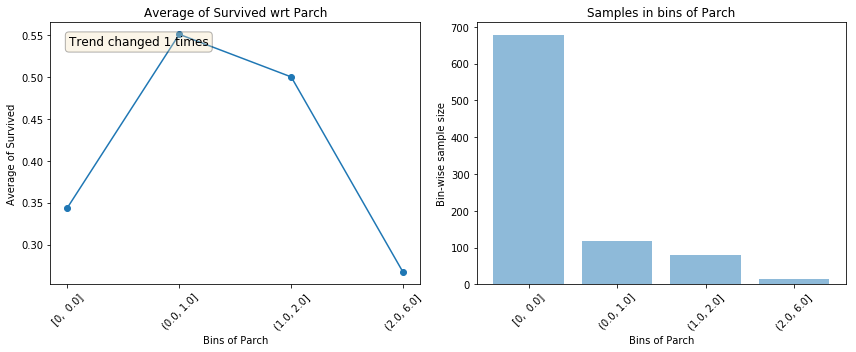

--------------------------------------------------------------------------------------------------------------


                                            Plots for Fare                                            


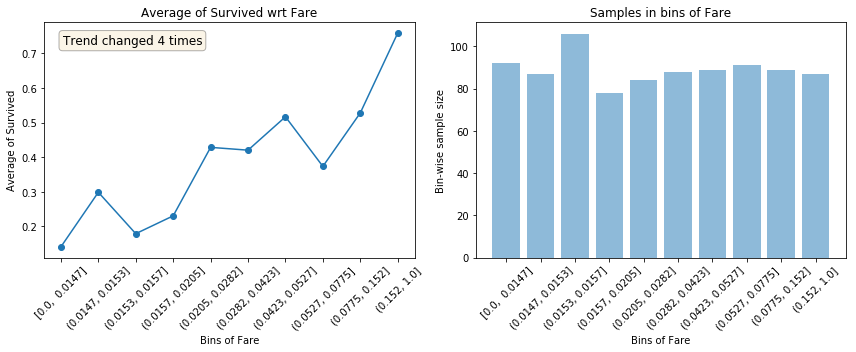

--------------------------------------------------------------------------------------------------------------


                                          Plots for Embarked                                          


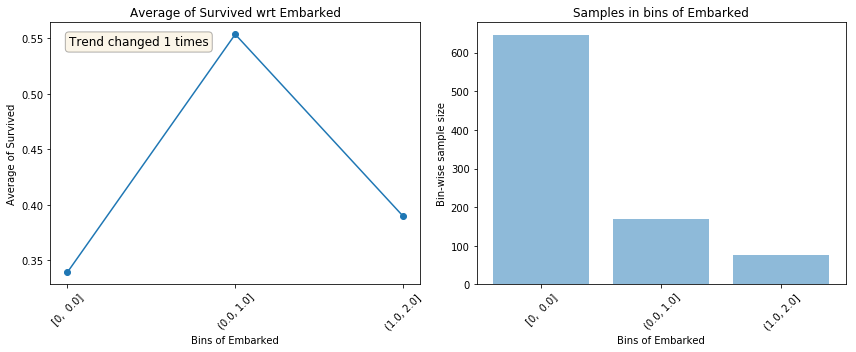

--------------------------------------------------------------------------------------------------------------


                                            Plots for Sex                                             


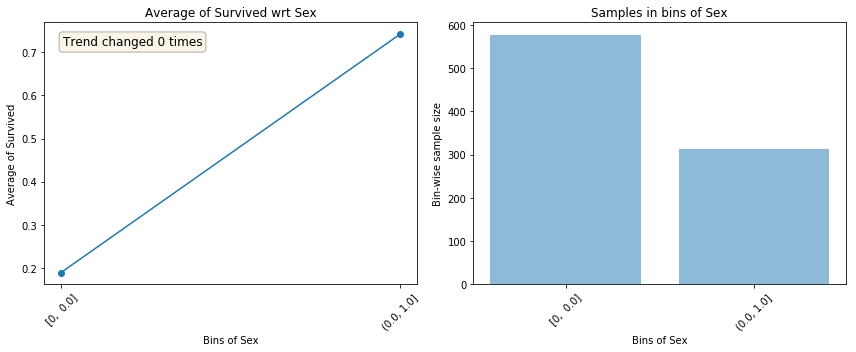

--------------------------------------------------------------------------------------------------------------


                                            Plots for Age                                             


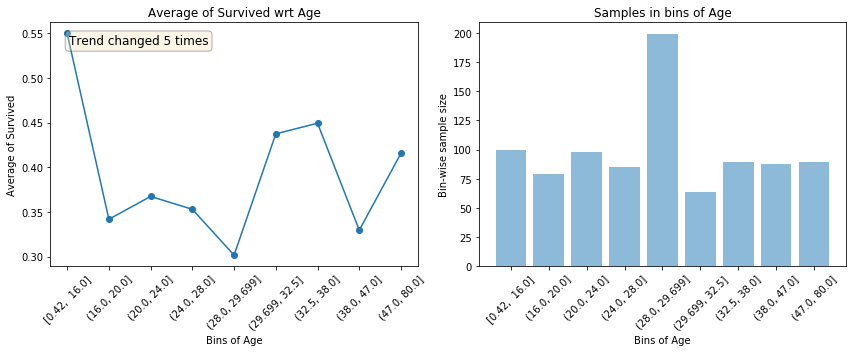

--------------------------------------------------------------------------------------------------------------




In [16]:
try:
    nums = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Sex']
    for feature in nums:
        featexp.get_univariate_plots(data=train_df.loc[train_df[feature].notnull()], target_col='Survived',
                              features_list=[feature], bins=10)
    featexp.get_univariate_plots(data=train_df.loc[train_df['Age'].notnull()], target_col='Survived',
                          features_list=['Age'], bins=10)
except NameError as e:
    print("Check intallation of featexp")
    print(str(e))

## Age Tranche/ Raw Age

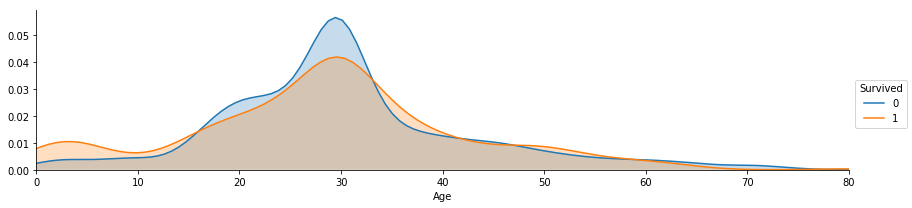

In [17]:
#plot distributions of age of passengers who survived or did not survive
a = sns.FacetGrid(train_df, hue = 'Survived', aspect=4 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , train_df['Age'].max()))
a.add_legend()

In [18]:
## Generate tranch of ages
age_df = train_df.copy()
age_test_df = test_df.copy()

age_df.loc[train_df["Age"]<14, "Age"] = 1
age_df.loc[train_df["Age"]>=14, "Age"] = 2

train_df.loc[train_df["Age"]<14, "Age"] = 1
train_df.loc[train_df["Age"]>=14, "Age"] = 0

test_df.loc[train_df["Age"]<14, "Age"] = 1
test_df.loc[train_df["Age"]>=14, "Age"] = 0
# age_df.loc[train_df["Age"]<31, "Age"] = 3
# age_df.loc[train_df["Age"]<41, "Age"] = 4
# age_df.loc[train_df["Age"]>=41, "Age"] = 4

# age_test_df.loc[test_df["Age"]<14, "Age"] = 1
# age_test_df.loc[test_df["Age"]<25, "Age"] = 2
# age_test_df.loc[test_df["Age"]<31, "Age"] = 3
# age_test_df.loc[test_df["Age"]<41, "Age"] = 4
# age_test_df.loc[test_df["Age"]>=41, "Age"] = 4

baseline(['Age'], age_df, age_test_df)
baseline(['Sex', 'Age', 'Pclass'], age_df, age_test_df)

,MLA Name,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time,MLA Parameters
0,AdaBoostClassifier,0.631648,0.623881,0.0714092,"{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}"
1,BaggingClassifier,0.631648,0.623881,0.0123669,"{'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
20,QuadraticDiscriminantAnalysis,0.631648,0.623881,0.000398827,"{'priors': None, 'reg_param': 0.0, 'store_covariance': False, 'store_covariances': None, 'tol': 0.0001}"
19,LinearDiscriminantAnalysis,0.631648,0.623881,0.00069809,"{'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}"
18,ExtraTreeClassifier,0.631648,0.623881,0.000299215,"{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'random'}"
17,DecisionTreeClassifier,0.631648,0.623881,0.000199461,"{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}"
16,LinearSVC,0.631648,0.623881,0.00349042,"{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}"
14,SVC,0.631648,0.623881,0.0202457,"{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}"
12,GaussianNB,0.631648,0.623881,0.000598288,{'priors': None}
21,XGBClassifier,0.631648,0.623881,0.0086767,"{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}"


,MLA Name,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time,MLA Parameters
1,BaggingClassifier,0.807116,0.796642,0.0127659,"{'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
3,GradientBoostingClassifier,0.808614,0.795896,0.059441,"{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': None, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}"
4,RandomForestClassifier,0.808427,0.795149,0.0143617,"{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
5,GaussianProcessClassifier,0.806367,0.794776,0.138729,"{'copy_X_train': True, 'kernel': None, 'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_jobs': 1, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None, 'warm_start': False}"
2,ExtraTreesClassifier,0.808614,0.794403,0.0132646,"{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
18,ExtraTreeClassifier,0.808614,0.794403,0.000299239,"{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'random'}"
17,DecisionTreeClassifier,0.808614,0.794403,0.000299168,"{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}"
21,XGBClassifier,0.807678,0.792537,0.0157578,"{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}"
19,LinearDiscriminantAnalysis,0.795131,0.790672,0.000897503,"{'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}"
0,AdaBoostClassifier,0.795131,0.790672,0.0720074,"{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}"


## Social Status 

In [19]:
train_df['Title'] = train_df['Name']
test_df["Title"] = test_df['Name']
get_title = lambda x: re.findall(r",\s(.+?)\.", x)[0]
train_df['Title'] = train_df['Title'].apply(get_title)
test_df['Title'] = test_df['Title'].apply(get_title)
print(train_df['Title'].value_counts())
print(test_df['Title'].value_counts())

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Major             2
Mlle              2
the Countess      1
Lady              1
Capt              1
Mme               1
Jonkheer          1
Ms                1
Sir               1
Don               1
Name: Title, dtype: int64
Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dr          1
Dona        1
Ms          1
Name: Title, dtype: int64


### Differences between social status

In [20]:
titles = train_df['Title'].unique()
Title_Survived_Rate = pd.DataFrame(columns=titles)

for title in titles:
    Title_Survived_Rate.loc['Survived Rate', title] = train_df.loc[(train_df['Title']==title) & (train_df['Survived']==1)].shape[0]/train_df.loc[train_df['Title']==title].shape[0] 
    Title_Survived_Rate.loc['% of Persons', title] = train_df.loc[train_df['Title']==title].shape[0] / train_df.shape[0]
    
s = Title_Survived_Rate.copy().style.applymap(color_05_red, subset=pd.IndexSlice[['Survived Rate'], titles])

s.format('{:.1%}')

,Mr,Mrs,Miss,Master,Don,Rev,Dr,Mme,Ms,Major,Lady,Sir,Mlle,Col,Capt,the Countess,Jonkheer
Survived Rate,15.7%,79.2%,69.8%,57.5%,0.0%,0.0%,42.9%,100.0%,100.0%,50.0%,100.0%,100.0%,100.0%,50.0%,0.0%,100.0%,0.0%
% of Persons,58.0%,14.0%,20.4%,4.5%,0.1%,0.7%,0.8%,0.1%,0.1%,0.2%,0.1%,0.1%,0.2%,0.2%,0.1%,0.1%,0.1%


In [21]:
Title_Survived_Rate = Title_Survived_Rate.T

In [22]:
high_risk = list(Title_Survived_Rate.loc[Title_Survived_Rate['Survived Rate']<=0.3].copy().T)
medium_risk = list(Title_Survived_Rate.loc[(Title_Survived_Rate['Survived Rate']>0.3) & (Title_Survived_Rate['Survived Rate']<0.6)].copy().T)
low_risk =  list(Title_Survived_Rate.loc[Title_Survived_Rate['Survived Rate']>0.6].copy().T)    

d1 = {x: 2 for x in high_risk}
d2 = {x: 1 for x in medium_risk}
d3 = {x: 0 for x in low_risk}

d = {**d1, **d2, **d3}
print(d)

# Do not run this line two times in one session due to map
train_df['Title'] = train_df['Title'].map(d)
train_df.head()

{'Mr': 2, 'Don': 2, 'Rev': 2, 'Capt': 2, 'Jonkheer': 2, 'Master': 1, 'Dr': 1, 'Major': 1, 'Col': 1, 'Mrs': 0, 'Miss': 0, 'Mme': 0, 'Ms': 0, 'Lady': 0, 'Sir': 0, 'Mlle': 0, 'the Countess': 0}


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,0.0,1,0,A/5 21171,0.014151,G6,0,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0.0,1,0,PC 17599,0.139136,C85,1,0
2,3,1,3,"Heikkinen, Miss. Laina",1,0.0,0,0,STON/O2. 3101282,0.015469,G6,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0.0,1,0,113803,0.103644,C123,0,0
4,5,0,3,"Allen, Mr. William Henry",0,0.0,0,0,373450,0.015713,G6,0,2


In [23]:
test_map = {'Mr': 2, "Mrs": 0, "Miss": 0, "Master": 1, "Col":2, "Rev": 2, "Dr": 1, "Dona": 1, 'Ms': 0}
test_df['Title'] = test_df["Title"].map(test_map)
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",0,1.0,0,0,330911,0.015282,B57 B59 B63 B66,2,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,1.0,1,0,363272,0.013663,B57 B59 B63 B66,0,0
2,894,2,"Myles, Mr. Thomas Francis",0,1.0,0,0,240276,0.018909,B57 B59 B63 B66,2,2
3,895,3,"Wirz, Mr. Albert",0,1.0,0,0,315154,0.016908,B57 B59 B63 B66,0,2
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,1.0,1,1,3101298,0.023984,B57 B59 B63 B66,0,0


In [24]:
baseline(['Title'], train_df, test_df)
baseline(['Sex', 'Pclass', 'Age', 'Title'], train_df, test_df)

,MLA Name,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time,MLA Parameters
11,BernoulliNB,0.788202,0.78806,0.000598359,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True}"
20,QuadraticDiscriminantAnalysis,0.788202,0.78806,0.000299144,"{'priors': None, 'reg_param': 0.0, 'store_covariance': False, 'store_covariances': None, 'tol': 0.0001}"
19,LinearDiscriminantAnalysis,0.788202,0.78806,0.000498652,"{'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}"
16,LinearSVC,0.788202,0.78806,0.00329099,"{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}"
6,LogisticRegressionCV,0.788202,0.78806,0.0366021,"{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'refit': True, 'scoring': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0}"
8,RidgeClassifierCV,0.788202,0.78806,0.000997305,"{'alphas': (0.1, 1.0, 10.0), 'class_weight': None, 'cv': None, 'fit_intercept': True, 'normalize': False, 'scoring': None}"
12,GaussianNB,0.788202,0.78806,0.000498796,{'priors': None}
1,BaggingClassifier,0.796629,0.785075,0.0126662,"{'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
15,NuSVC,0.796629,0.785075,0.0200463,"{'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'nu': 0.5, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}"
14,SVC,0.796629,0.785075,0.0156579,"{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}"


,MLA Name,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time,MLA Parameters
15,NuSVC,0.798689,0.795896,0.0288227,"{'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'nu': 0.5, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}"
6,LogisticRegressionCV,0.802996,0.795149,0.0682176,"{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'refit': True, 'scoring': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0}"
8,RidgeClassifierCV,0.802247,0.793284,0.00129659,"{'alphas': (0.1, 1.0, 10.0), 'class_weight': None, 'cv': None, 'fit_intercept': True, 'normalize': False, 'scoring': None}"
16,LinearSVC,0.801873,0.79291,0.0106715,"{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}"
0,AdaBoostClassifier,0.801873,0.792537,0.0718078,"{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}"
19,LinearDiscriminantAnalysis,0.801685,0.791418,0.000997472,"{'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}"
3,GradientBoostingClassifier,0.810487,0.790299,0.0599396,"{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': None, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}"
2,ExtraTreesClassifier,0.811423,0.789552,0.0131649,"{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
12,GaussianNB,0.796816,0.789552,0.000498724,{'priors': None}
18,ExtraTreeClassifier,0.811423,0.789179,0.000398946,"{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'random'}"


## Embarked

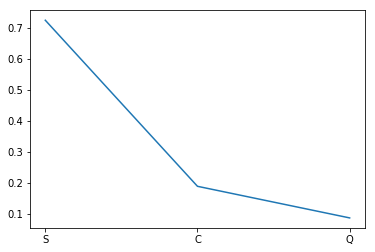

In [25]:
plt.figure()
Embarked_Survived_Rate = [train_df.loc[train_df['Embarked']==i].shape[0]/train_df.shape[0] for i in range(3)]
plt.plot(['S', 'C', 'Q'], Embarked_Survived_Rate)

In [26]:
baseline(['Embarked'], train_df, test_df)
baseline(['Sex', 'Pclass', 'Title', "Embarked"], train_df, test_df)

,MLA Name,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time,MLA Parameters
0,AdaBoostClassifier,0.635581,0.627239,0.0709105,"{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}"
1,BaggingClassifier,0.635581,0.627239,0.0123671,"{'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
18,ExtraTreeClassifier,0.635581,0.627239,0.000299168,"{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'random'}"
17,DecisionTreeClassifier,0.635581,0.627239,0.000299263,"{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}"
14,SVC,0.635581,0.627239,0.0259305,"{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}"
21,XGBClassifier,0.635581,0.627239,0.0100729,"{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}"
5,GaussianProcessClassifier,0.635581,0.627239,0.109507,"{'copy_X_train': True, 'kernel': None, 'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_jobs': 1, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None, 'warm_start': False}"
4,RandomForestClassifier,0.635581,0.627239,0.0139627,"{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
3,GradientBoostingClassifier,0.635581,0.627239,0.0362032,"{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': None, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}"
2,ExtraTreesClassifier,0.635581,0.627239,0.0127658,"{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"


,MLA Name,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time,MLA Parameters
21,XGBClassifier,0.829588,0.824627,0.0181512,"{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}"
5,GaussianProcessClassifier,0.827903,0.824627,0.14571,"{'copy_X_train': True, 'kernel': None, 'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_jobs': 1, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None, 'warm_start': False}"
3,GradientBoostingClassifier,0.830337,0.823507,0.062134,"{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': None, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}"
14,SVC,0.827903,0.823507,0.0226394,"{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}"
1,BaggingClassifier,0.829963,0.823134,0.0132647,"{'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
2,ExtraTreesClassifier,0.830712,0.822761,0.0133641,"{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
4,RandomForestClassifier,0.829963,0.822015,0.0145612,"{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
18,ExtraTreeClassifier,0.830712,0.822015,0.000398946,"{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'random'}"
17,DecisionTreeClassifier,0.830712,0.821269,0.00039885,"{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}"
19,LinearDiscriminantAnalysis,0.799625,0.793284,0.000997233,"{'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}"


In [27]:
data_df = train_df.append(test_df)
data_df['Fare'].fillna(data_df['Fare'].median(), inplace = True)

# Making Bins
data_df['FareBin'] = pd.qcut(data_df['Fare'], 5)

label = LabelEncoder()
data_df['FareBin_Code'] = label.fit_transform(data_df['FareBin'])

train_df['FareBin_Code'] = data_df['FareBin_Code'][:891]
test_df['FareBin_Code'] = data_df['FareBin_Code'][891:]

# Some internal relationship between passengers

We have spend enough time over the gender model (~0.78), but we did not get a significant improvement over the original Sex only model which get an accuracy about 0.76.

## Grouped or not

In [28]:
train_df['Grouped'] = train_df['Name']
train_df.loc[train_df['SibSp']+train_df['Parch']>0, "Grouped"] = 1
train_df.loc[train_df['SibSp']+train_df['Parch']==0, "Grouped"] = 0
test_df['Grouped'] = test_df['Name']
test_df.loc[test_df['SibSp']+test_df['Parch']>0, "Grouped"] = 1
test_df.loc[test_df['SibSp']+test_df['Parch']==0, "Grouped"] = 0
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FareBin_Code,Grouped
0,1,0,3,"Braund, Mr. Owen Harris",0,0.0,1,0,A/5 21171,0.014151,G6,0,2,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0.0,1,0,PC 17599,0.139136,C85,1,0,4,1
2,3,1,3,"Heikkinen, Miss. Laina",1,0.0,0,0,STON/O2. 3101282,0.015469,G6,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0.0,1,0,113803,0.103644,C123,0,0,4,1
4,5,0,3,"Allen, Mr. William Henry",0,0.0,0,0,373450,0.015713,G6,0,2,1,0


                                          Plots for Grouped                                           


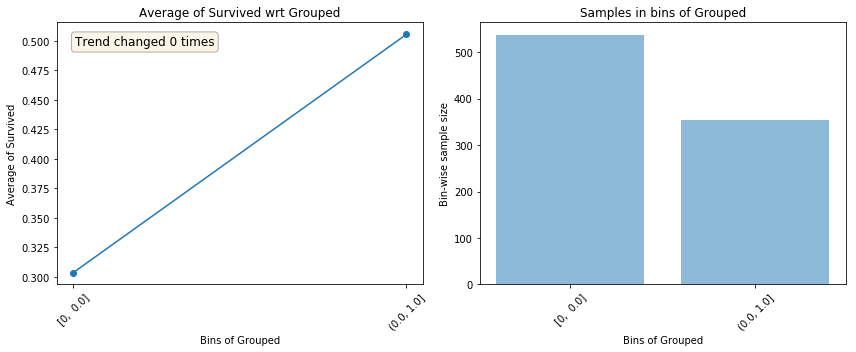

--------------------------------------------------------------------------------------------------------------




In [29]:
featexp.get_univariate_plots(data=train_df.loc[train_df["Grouped"].notnull()], target_col='Survived',
                              features_list=["Grouped"], bins=10)

In [30]:
baseline(['Grouped', 'Sex', "Pclass", "Title", "Embarked"], train_df, test_df)

,MLA Name,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time,MLA Parameters
5,GaussianProcessClassifier,0.83015,0.820896,0.139626,"{'copy_X_train': True, 'kernel': None, 'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_jobs': 1, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None, 'warm_start': False}"
21,XGBClassifier,0.831648,0.820522,0.0188495,"{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}"
3,GradientBoostingClassifier,0.832772,0.820149,0.0655248,"{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': None, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}"
4,RandomForestClassifier,0.833708,0.820149,0.0149601,"{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
2,ExtraTreesClassifier,0.834457,0.819776,0.0139627,"{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
14,SVC,0.827341,0.819403,0.0247339,"{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}"
18,ExtraTreeClassifier,0.834457,0.81791,0.000398922,"{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'random'}"
17,DecisionTreeClassifier,0.834457,0.816418,0.000398827,"{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}"
1,BaggingClassifier,0.833521,0.816418,0.0137632,"{'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
20,QuadraticDiscriminantAnalysis,0.811798,0.797388,0.00039885,"{'priors': None, 'reg_param': 0.0, 'store_covariance': False, 'store_covariances': None, 'tol': 0.0001}"


## Family Size

In [31]:
train_df['FamilySize'] = train_df['SibSp']+train_df["Parch"]
test_df['FamilySize'] = test_df['SibSp']+test_df["Parch"]
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FareBin_Code,Grouped,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",0,0.0,1,0,A/5 21171,0.014151,G6,0,2,0,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0.0,1,0,PC 17599,0.139136,C85,1,0,4,1,1
2,3,1,3,"Heikkinen, Miss. Laina",1,0.0,0,0,STON/O2. 3101282,0.015469,G6,0,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0.0,1,0,113803,0.103644,C123,0,0,4,1,1
4,5,0,3,"Allen, Mr. William Henry",0,0.0,0,0,373450,0.015713,G6,0,2,1,0,0


                                         Plots for FamilySize                                         


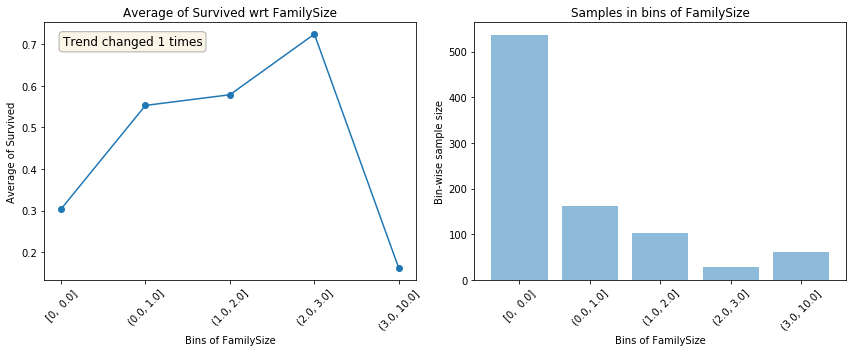

--------------------------------------------------------------------------------------------------------------




In [32]:
featexp.get_univariate_plots(data=train_df.loc[train_df["FamilySize"].notnull()], target_col='Survived',
                              features_list=["FamilySize"], bins=10)

In [33]:
baseline([ 'Sex', "FareBin_Code", "Title", "Embarked", "FamilySize"], train_df, test_df)

,MLA Name,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time,MLA Parameters
5,GaussianProcessClassifier,0.842322,0.827612,0.138131,"{'copy_X_train': True, 'kernel': None, 'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_jobs': 1, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None, 'warm_start': False}"
14,SVC,0.832959,0.824254,0.035904,"{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}"
3,GradientBoostingClassifier,0.847004,0.823134,0.0647268,"{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': None, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}"
21,XGBClassifier,0.83839,0.822015,0.0188497,"{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1}"
16,LinearSVC,0.822097,0.814552,0.0243348,"{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}"
0,AdaBoostClassifier,0.823221,0.814179,0.0730047,"{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}"
15,NuSVC,0.823596,0.813433,0.0362032,"{'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'nu': 0.5, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}"
19,LinearDiscriminantAnalysis,0.820225,0.813433,0.000997329,"{'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}"
6,LogisticRegressionCV,0.821161,0.811567,0.0720074,"{'Cs': 10, 'class_weight': None, 'cv': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1.0, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': None, 'refit': True, 'scoring': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0}"
17,DecisionTreeClassifier,0.858427,0.811194,0.000598478,"{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}"


## Family Survival

In [34]:

data_df['Last_Name'] = data_df['Name'].apply(lambda x: str.split(x, ",")[0])
data_df['Fare'].fillna(data_df['Fare'].mean(), inplace=True)

DEFAULT_SURVIVAL_VALUE = 0.5
data_df['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in data_df[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      data_df.loc[data_df['Family_Survival']!=0.5].shape[0])

for _, grp_df in data_df.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with family/group survival information: " 
      +str(data_df[data_df['Family_Survival']!=0.5].shape[0]))

# # Family_Survival in TRAIN_DF and TEST_DF:
train_df['Family_Survival'] = data_df['Family_Survival'][:891]
test_df['Family_Survival'] = data_df['Family_Survival'][891:]

Number of passengers with family survival information: 420
Number of passenger with family/group survival information: 546


# Feature Selection

In [35]:
from sklearn.feature_selection import RFE

features = ['Age', 'Pclass', 'Embarked', 'Family_Survival', 'FamilySize', 'Title', 'Sex']
clf = RandomForestClassifier()
rfe = RFE(estimator=clf, n_features_to_select=1, step=1)
fit = rfe.fit(train_df[features], train_df['Survived'])
print("Feature Ranking: {}".format(fit.ranking_))


Feature Ranking: [7 3 6 2 4 1 5]


# Tuning parameters

In [75]:
features = [ "Title"]
std_scaler = sklearn.preprocessing.StandardScaler()
train_df[feature] = std_scaler.fit_transform(train_df[features])
test_df[feature] = std_scaler.transform(test_df[features])

In [76]:

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )

#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
#removed models w/o attribute 'predict_proba' required for vote classifier and models with a 1.0 correlation to another model
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),

    #Gaussian Processes: http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    #GLM: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    ('lr', linear_model.LogisticRegressionCV()),
    
    #Navies Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsClassifier()),
    
    #SVM: http://scikit-learn.org/stable/modules/svm.html
    ('svc', svm.SVC(probability=True)),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
   ('xgb', XGBClassifier())

]


#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, train_df[features], train_df["Survived"], cv  = cv_split)
vote_hard.fit(train_df[features], train_df["Survived"])

print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)


#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, train_df[features], train_df["Survived"], cv  = cv_split)
vote_soft.fit(train_df[features], train_df["Survived"])

print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)


#Hyperparameter Tune with GridSearchCV: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_n_estimator = range(10, 300, 50)
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .75, .1, .15, .25]
grid_max_depth = [2, 3, 4, 5, 6, 7, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]


grid_param = [
            [{
            #AdaBoostClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
            'n_estimators': grid_n_estimator, #default=50
            'learning_rate': grid_learn, #default=1
            #'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
            'random_state': grid_seed
            }],
       
    
            [{
            #BaggingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier
            'n_estimators': grid_n_estimator, #default=10
            'max_samples': grid_ratio, #default=1.0
            'random_state': grid_seed
             }],

    
            [{
            #ExtraTreesClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'random_state': grid_seed
             }],


            [{
            #GradientBoostingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
            #'loss': ['deviance', 'exponential'], #default=’deviance’
            'learning_rate': [.05], #default=0.1 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            'n_estimators': [300], #default=100 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            #'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
            'max_depth': grid_max_depth, #default=3   
            'random_state': grid_seed
             }],

    
            [{
            #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
            'random_state': grid_seed
             }],
    
            [{    
            #GaussianProcessClassifier
            'max_iter_predict': grid_n_estimator, #default: 100
            'random_state': grid_seed
            }],
        
    
            [{
            #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
            'fit_intercept': grid_bool, #default: True
            #'penalty': ['l1','l2'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], #default: lbfgs
            'random_state': grid_seed
             }],
            
    
            [{
            #BernoulliNB - http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB
            'alpha': grid_ratio, #default: 1.0
             }],
    
    
            #GaussianNB - 
            [{}],
    
            [{
            #KNeighborsClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
            'n_neighbors': [6,7,8,9,10,11,12,14,16,18,20,22], #default: 5
            'weights': ['uniform', 'distance'], #default = ‘uniform’
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': list(range(1,50,5))
            }],
            
    
            [{
            #SVC - http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
            #http://blog.hackerearth.com/simple-tutorial-svm-parameter-tuning-python-r
            #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [1,2,3,4,5], #default=1.0
            'gamma': grid_ratio, #edfault: auto
            'decision_function_shape': ['ovo', 'ovr'], #default:ovr
            'probability': [True],
            'random_state': grid_seed
             }],

    
            [{
            #XGBClassifier - http://xgboost.readthedocs.io/en/latest/parameter.html
            'learning_rate': grid_learn, #default: .3
            'max_depth': [1,2,4,6,8,10], #default 2
            'n_estimators': grid_n_estimator, 
            'seed': grid_seed  
             }]   
        ]



start_total = time.perf_counter() #https://docs.python.org/3/library/time.html#time.perf_counter
for clf, param in zip (vote_est, grid_param): #https://docs.python.org/3/library/functions.html#zip

    #print(clf[1]) #vote_est is a list of tuples, index 0 is the name and index 1 is the algorithm
    #print(param)
    
    
    start = time.perf_counter()        
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc', n_jobs=-1, return_train_score=True)
    best_search.fit(train_df[features], train_df["Survived"])
    run = time.perf_counter() - start
    
    results = best_search.cv_results_
    best_param = best_search.best_params_
    best_index = results['params'].index(best_param)
    print('The best train mean score {} test {} parameter for {} is {} with a runtime of {:.2f} seconds.'.format(results['mean_train_score'][best_index],results['mean_test_score'][best_index] , clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param) 


run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

Hard Voting Training w/bin score mean: 79.66
Hard Voting Test w/bin score mean: 78.40
Hard Voting Test w/bin score 3*std: +/- 4.63
----------
Soft Voting Training w/bin score mean: 79.64
Soft Voting Test w/bin score mean: 78.43
Soft Voting Test w/bin score 3*std: +/- 4.61
----------
The best train mean score 0.7961311918744091 test 0.7935829369771467 parameter for AdaBoostClassifier is {'learning_rate': 0.01, 'n_estimators': 210, 'random_state': 0} with a runtime of 28.40 seconds.
The best train mean score 0.7961311918744091 test 0.7935829369771467 parameter for BaggingClassifier is {'max_samples': 0.1, 'n_estimators': 60, 'random_state': 0} with a runtime of 22.18 seconds.
The best train mean score 0.7961311918744091 test 0.7935829369771467 parameter for ExtraTreesClassifier is {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 10, 'random_state': 0} with a runtime of 37.24 seconds.
The best train mean score 0.7961311918744091 test 0.7935829369771467 parameter for GradientBoostingC

# Submission

In [38]:
#Hard Vote or majority rules w/Tuned Hyperparameters
grid_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
grid_hard_cv = model_selection.cross_validate(grid_hard, train_df[features], train_df["Survived"], cv  = cv_split)
grid_hard.fit(train_df[features], train_df["Survived"])

print("Hard Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_hard_cv['train_score'].mean()*100)) 
print("Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_hard_cv['test_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_hard_cv['test_score'].std()*100*3))
print('-'*10)

#Soft Vote or weighted probabilities w/Tuned Hyperparameters
grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft, train_df[features], train_df["Survived"], cv  = cv_split)
grid_soft.fit(train_df[features], train_df["Survived"])

print("Soft Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_soft_cv['train_score'].mean()*100)) 
print("Soft Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_soft_cv['test_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_soft_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting w/Tuned Hyperparameters Training w/bin score mean: 83.48
Hard Voting w/Tuned Hyperparameters Test w/bin score mean: 83.32
Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 3.54
----------
Soft Voting w/Tuned Hyperparameters Training w/bin score mean: 83.39
Soft Voting w/Tuned Hyperparameters Test w/bin score mean: 83.54
Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 3.34
----------


In [78]:
#check data for modeling
print(test_df.info())
print("-"*10)

method = "hard"
# test_df = test_df.fillna(0)
nas = test_df.isnull().sum() 
print(nas)

# if method == "hard":
#     test_df['Survived'] = grid_hard.predict(test_df[features])
# elif method == "soft":
#     test_df['Survived'] = grid_soft.predict(test_df[features])
test_df["Survived"] = RandomForestClassifier(criterion='gini', max_depth=5, n_estimators=160, oob_score= True, random_state= 0).fit(train_df[features], train_df["Survived"]).predict(test_df[features]) #0.794
test_df["Survived"] = RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=10, oob_score= True, random_state= 0).fit(train_df[features], train_df["Survived"]).predict(test_df[features])
test_df["Survived"] = RandomForestClassifier(criterion='gini', max_depth=5, n_estimators=110, oob_score= True, random_state= 0).fit(train_df[features], train_df["Survived"]).predict(test_df[features]) #0.80 wih 'Sex', "Pclass", "Embarked", "FamilySize", "Family_Survival", 
# test_df["Survived"] = RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=260, oob_score= True, random_state= 0).fit(train_df[features], train_df["Survived"]).predict(test_df[features])
test_df["Survived"] = RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=260, oob_score= True, random_state= 0).fit(train_df[features], train_df["Survived"]).predict(test_df[features])
# test_df["Survived"] = ensemble.ExtraTreesClassifier(criterion='gini', max_depth=5, n_estimators=110, random_state= 0).fit(train_df[features], train_df["Survived"]).predict(test_df[features])
# test_df["Survived"] = ensemble.ExtraTreesClassifier(criterion='entropy', max_depth=6, n_estimators=10, random_state= 0).fit(train_df[features], train_df["Survived"]).predict(test_df[features])
# test_df.loc[test_df['Sex']==0, "Survived"] = 0

# current_clf = XGBClassifier(learning_rate= 0.05, max_depth= 2, n_estimators= 3000, seed= 0)
current_clf = RandomForestClassifier(criterion='gini', max_depth=2, n_estimators=10, oob_score= True, random_state= 0)
# current_clf = gaussian_process.GaussianProcessClassifier(max_iter_predict= 10, random_state= 0)
test_df["Survived"] = current_clf.fit(train_df[features], train_df["Survived"]).predict(test_df[features])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 17 columns):
PassengerId        418 non-null int64
Pclass             418 non-null int64
Name               418 non-null object
Sex                418 non-null float64
Age                418 non-null float64
SibSp              418 non-null int64
Parch              418 non-null int64
Ticket             418 non-null object
Fare               418 non-null float64
Cabin              418 non-null object
Embarked           418 non-null int64
Title              418 non-null int64
FareBin_Code       418 non-null int64
Grouped            418 non-null int64
FamilySize         418 non-null int64
Family_Survival    418 non-null float64
Survived           418 non-null int64
dtypes: float64(4), int64(10), object(3)
memory usage: 55.6+ KB
None
----------
PassengerId        0
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket     

In [79]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": test_df['Survived']
    })

file = 'titanic_preditedby{}_{}using_{}.csv'.format(current_clf.__class__.__name__, now, ''.join(features))
submission.to_csv(file, index=False)
print('Exported '+file)

Exported titanic_preditedbyRandomForestClassifier_20181202123725using_Title.csv


In [41]:
!kaggle competitions submit -c titanic -f {file} -m "Message"

Successfully submitted to Titanic: Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:05<00:00, 584B/s]
